0.9494
9
       ImageId  Label
0            1      2
1            2      0
2            3      9
3            4      7
4            5      3
5            6      7
6            7      0
7            8      3
8            9      0
9           10      3
10          11      5
11          12      7
12          13      4
13          14      0
14          15      4
15          16      3
16          17      3
17          18      1
18          19      9
19          20      0
20          21      9
21          22      1
22          23      1
23          24      5
24          25      7
25          26      4
26          27      2
27          28      9
28          29      7
29          30      7
...        ...    ...
27970    27971      5
27971    27972      0
27972    27973      4
27973    27974      8
27974    27975      0
27975    27976      3
27976    27977      6
27977    27978      0
27978    27979      1
27979    27980      9
27980    27981      3
27981    27982      1
27982    27983      8
2

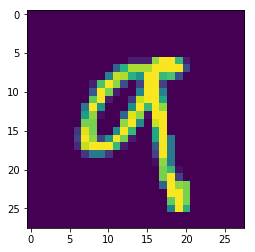

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf # Tensorflow for softmax and running the kernel
training_data = pd.read_csv(r"E:\Tensorflow project dataset\train.csv")
                            
testing_data = pd.read_csv(r"E:\Tensorflow project dataset\test.csv")
#print(training_data.head())
#print(testing_data.head())

class Dataset(object):
    def __init__(self, data):
        self.rows = len(data.values)
        self.images = data.iloc[:,1:].values
        self.images = self.images.astype(np.float32)
        self.images = np.multiply(self.images, 1.0 / 255.0)
        self.labels = np.array([np.array([int(i == l) for i in range(10)]) for l in data.iloc[:,0].values]) #one-hot
        self.index_in_epoch = 0
        self.epoch = 0
    def next_batch(self, batch_size):
        start = self.index_in_epoch
        self.index_in_epoch += batch_size
        if self.index_in_epoch > self.rows:
            self.epoch += 1
            perm = np.arange(self.rows)
            np.random.shuffle(perm)
            self.images = self.images[perm]
            self.labels = self.labels[perm]
            #next epoch
            start = 0
            self.index_in_epoch = batch_size
        end = self.index_in_epoch
        return self.images[start:end] , self.labels[start:end]
x = tf.placeholder(tf.float32, [None, 784])
W = tf.Variable(tf.zeros([784,10]))
b = tf.Variable(tf.zeros([10]))

y = tf.nn.softmax(tf.matmul(x, W) + b)
y_ = tf.placeholder(tf.float32, [None, 10])

cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)
train_data = Dataset(training_data.iloc[37000:])
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

for i in range(1000):
    batch_xs, batch_ys = train_data.next_batch(100)
    sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

validate_data = Dataset(training_data.iloc[37000:])
print(sess.run(accuracy, feed_dict={x: validate_data.images, y_: validate_data.labels}))
import matplotlib.pyplot as plt
plt.imshow(validate_data.images[0].reshape(28,28)) 
print(np.argmax(sess.run(y, feed_dict={x:validate_data.images[:1]})))
test_images = testing_data.values.astype(np.float32)
test_images = np.multiply(test_images, 1.0 / 255.0)

predictions = sess.run(y, feed_dict={x:test_images})
predictions = [np.argmax(p) for p in predictions]

result = pd.DataFrame({'ImageId': range(1,len(predictions)+1), 'Label': predictions})
result.to_csv('result.csv', index=False, encoding='utf-8')
print(result)
